In [ ]:
!pip install numpy pandas matplotlib seaborn scikit-learn nltk



In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/fake_news.csv')  # Update the path accordingly
df.head()


,title,news_url,source_domain,tweet_num,real
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1


In [4]:
print(df.info())  # Check data types and missing values
print(df.head())  # View the first few rows
print(df['label'].value_counts())  # Check class distribution


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23196 entries, 0 to 23195
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          23196 non-null  object
 1   news_url       22866 non-null  object
 2   source_domain  22866 non-null  object
 3   tweet_num      23196 non-null  int64 
 4   real           23196 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 906.2+ KB
None
                                               title  \
0  Kandi Burruss Explodes Over Rape Accusation on...   
1  People's Choice Awards 2018: The best red carp...   
2  Sophia Bush Sends Sweet Birthday Message to 'O...   
3  Colombian singer Maluma sparks rumours of inap...   
4  Gossip Girl 10 Years Later: How Upper East Sid...   

                                            news_url        source_domain  \
0  http://toofab.com/2017/05/08/real-housewives-a...           toofab.com   
1  https://www.today.com/style/see-people-s

KeyError: 'label'

In [5]:
# Rename "real" column to "label" for consistency
df.rename(columns={'real': 'label'}, inplace=True)

# Convert to categorical format (1 = Real, 0 = Fake)
df['label'] = df['label'].map({1: "REAL", 0: "FAKE"})

# Now check class distribution again
print(df['label'].value_counts())


label
REAL    17441
FAKE     5755
Name: count, dtype: int64


In [6]:
import re
import nltk
from nltk.corpus import stopwords

# Download stopwords if not already downloaded
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    if pd.isna(text):  # Handle missing values
        return ""
    text = str(text).lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = ' '.join(word for word in text.split() if word not in stop_words)  # Remove stopwords
    return text

# Apply cleaning to "title" column
df['clean_text'] = df['title'].astype(str).apply(clean_text)

# Check cleaned text
print(df[['title', 'clean_text']].head())


                                               title  \
0  Kandi Burruss Explodes Over Rape Accusation on...   
1  People's Choice Awards 2018: The best red carp...   
2  Sophia Bush Sends Sweet Birthday Message to 'O...   
3  Colombian singer Maluma sparks rumours of inap...   
4  Gossip Girl 10 Years Later: How Upper East Sid...   

                                          clean_text  
0  kandi burruss explodes rape accusation real ho...  
1        peoples choice awards best red carpet looks  
2  sophia bush sends sweet birthday message one t...  
3  colombian singer maluma sparks rumours inappro...  
4  gossip girl years later upper east siders shoc...  


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


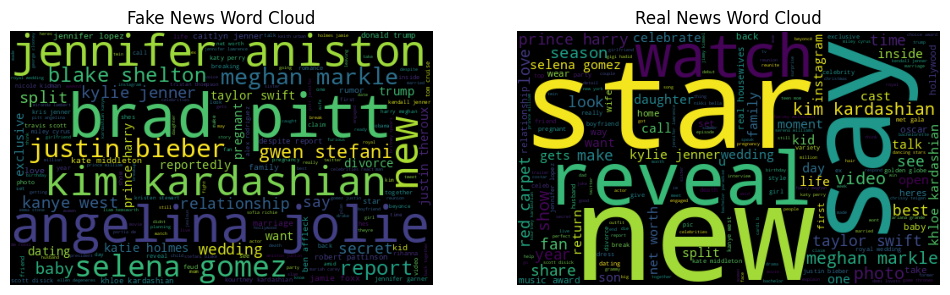

In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate word clouds
fake_text = " ".join(df[df['label'] == "FAKE"]['clean_text'])
real_text = " ".join(df[df['label'] == "REAL"]['clean_text'])

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Fake News Word Cloud")
plt.imshow(WordCloud(width=500, height=300, background_color='black').generate(fake_text))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Real News Word Cloud")
plt.imshow(WordCloud(width=500, height=300, background_color='black').generate(real_text))
plt.axis("off")

plt.show()


In [8]:
df['text_length'] = df['clean_text'].apply(lambda x: len(x.split()))
df.groupby('label')['text_length'].describe()


,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
FAKE,5755.0,8.049001,2.626374,1.0,6.0,8.0,10.0,24.0
REAL,17441.0,7.970128,2.643035,0.0,6.0,8.0,10.0,35.0


In [ ]:
!pip install -U scikit-learn


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limit features to reduce complexity

# Transform 'clean_text' column into numerical features
X = tfidf_vectorizer.fit_transform(df['clean_text'])

# Define target variable (1 = Real, 0 = Fake)
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Initialize model
model = LogisticRegression()

# Train the model
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Print accuracy and classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8301724137931035

Classification Report:
               precision    recall  f1-score   support

        FAKE       0.76      0.44      0.56      1131
        REAL       0.84      0.96      0.89      3509

    accuracy                           0.83      4640
   macro avg       0.80      0.70      0.73      4640
weighted avg       0.82      0.83      0.81      4640



In [10]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)


In [11]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=200)
model.fit(X_train, y_train)


RandomForestClassifier(n_estimators=200)

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['clean_text'])


In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define the model
model = LogisticRegression()

# Define hyperparameters to tune
param_grid = {
    'C': [0.01, 0.1, 1, 10],  # Regularization strength
    'solver': ['liblinear', 'lbfgs'],  # Optimization algorithm
}

# Grid search
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters & accuracy
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)


Best Hyperparameters: {'C': 1, 'solver': 'liblinear'}
Best Accuracy: 0.8335848136713778


In [14]:
best_model = LogisticRegression(C=1, solver='liblinear')
best_model.fit(X_train, y_train)


LogisticRegression(C=1, solver='liblinear')

In [15]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = best_model.predict(X_test)

print("Final Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Final Accuracy: 0.8303879310344827
Classification Report:
               precision    recall  f1-score   support

        FAKE       0.76      0.44      0.56      1131
        REAL       0.84      0.96      0.89      3509

    accuracy                           0.83      4640
   macro avg       0.80      0.70      0.73      4640
weighted avg       0.82      0.83      0.81      4640



In [ ]:
from flask import Flask, request, jsonify
import joblib

app = Flask(__name__)

# Load the trained model & vectorizer
model = joblib.load("fake_news_model.pkl")
vectorizer = joblib.load("vectorizer.pkl")

@app.route('/predict', methods=['POST'])
def predict():
    data = request.json
    text = data.get('text')
    if not text:
        return jsonify({"error": "No text provided"}), 400

    text_vectorized = vectorizer.transform([text])
    prediction = model.predict(text_vectorized)[0]

    return jsonify({"prediction": "REAL" if prediction == 1 else "FAKE"})

if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat


In [ ]:
import os
print(os.listdir())


['.config', 'drive', 'sample_data']


In [19]:
import joblib

# Save the trained model
joblib.dump(model, "fake_news_model.pkl")

# Save the TF-IDF vectorizer
joblib.dump(vectorizer, "vectorizer.pkl")


['vectorizer.pkl']

In [20]:
model = joblib.load("fake_news_model.pkl")
vectorizer = joblib.load("vectorizer.pkl")


In [21]:
from flask import Flask, request, jsonify
import joblib

app = Flask(__name__)

# Load the trained model & vectorizer
model = joblib.load("fake_news_model.pkl")
vectorizer = joblib.load("vectorizer.pkl")

@app.route('/predict', methods=['POST'])
def predict():
    data = request.json
    text = data.get('text')
    if not text:
        return jsonify({"error": "No text provided"}), 400

    text_vectorized = vectorizer.transform([text])
    prediction = model.predict(text_vectorized)[0]

    return jsonify({"prediction": "REAL" if prediction == 1 else "FAKE"})

if __name__ == '__main__':
    app.run(host="0.0.0.0", port=10000)  # Render uses port 10000


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:10000
 * Running on http://172.28.0.12:10000
INFO:werkzeug:Press CTRL+C to quit


In [22]:
import joblib

# Save the trained model
joblib.dump(model, "fake_news_model.pkl")

# Save the vectorizer
joblib.dump(vectorizer, "vectorizer.pkl")

# Download files (Google Colab only)
from google.colab import files
files.download("fake_news_model.pkl")
files.download("vectorizer.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>